In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_csv("routing_log_05062025.csv")
df2 = pd.read_csv("routing_log_05052025.csv")
df = pd.concat([df1, df2], ignore_index=True)

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

start_time = pd.to_datetime("22:00:00").time()  # 6:00 AM UTC+8
end_time = pd.to_datetime("01:00:00").time()    # 9:00 AM UTC+8

df['time_only'] = df['timestamp'].dt.time

# Filter time
filtered_df = df[
    (df['time_only'] >= start_time) | (df['time_only'] <= end_time)
].drop(columns=['time_only'])

df = filtered_df

# Extract route category
df['category'] = df['route_type'].str.extract(r'(fastest|greenest|balanced|shortest)')
df['vehicle'] = df['vehicle'].str.lower()

In [60]:
summary = {}
metrics = ['distance', 'time', 'weight']

for vehicle, group in df.groupby('vehicle'):
    comp_df = group.set_index('category').loc[['fastest', 'greenest', 'balanced', 'shortest'], metrics]
    summary[vehicle] = comp_df

for vehicle, comp_df in summary.items():
    print(f"\n=== {vehicle.upper()} ROUTE COMPARISON ===")
    print(comp_df.sort_index())


=== BIKE ROUTE COMPARISON ===
              distance        time    weight
category                                    
balanced  2.089528e+04    4486.295   27759.0
balanced  1.787107e+04    3912.711   72764.0
balanced  7.419219e+03    1484.789    3968.0
balanced  1.989760e+04    4352.517   32093.0
balanced  1.526573e+04    3473.805    9346.0
...                ...         ...       ...
shortest  9.396946e+03    1956.384   45402.0
shortest  1.253976e+02      45.143     500.0
shortest  9.702186e+03    2225.621   50435.0
shortest  1.500280e+06  505298.250  207500.0
shortest  6.096498e+03    1313.495   64500.0

[1840 rows x 3 columns]

=== CAR ROUTE COMPARISON ===
            distance      time   weight
category                               
balanced  24224.8570  1852.873  29959.0
balanced   8233.9360   906.195   3947.0
balanced  22225.1600  2330.942  33032.0
balanced  20329.8980  1912.651  49533.0
balanced  32928.1840  3183.280  61770.0
...              ...       ...      ...
shortest 


=== BIKE ROUTE COMPARISON ===
           distance      time    weight
category                               
fastest   174513.21  45598.30  83533.12
greenest  160346.13  57631.74  49376.62
balanced  177012.92  46641.58  49827.97
shortest  155269.09  55405.02  83368.42


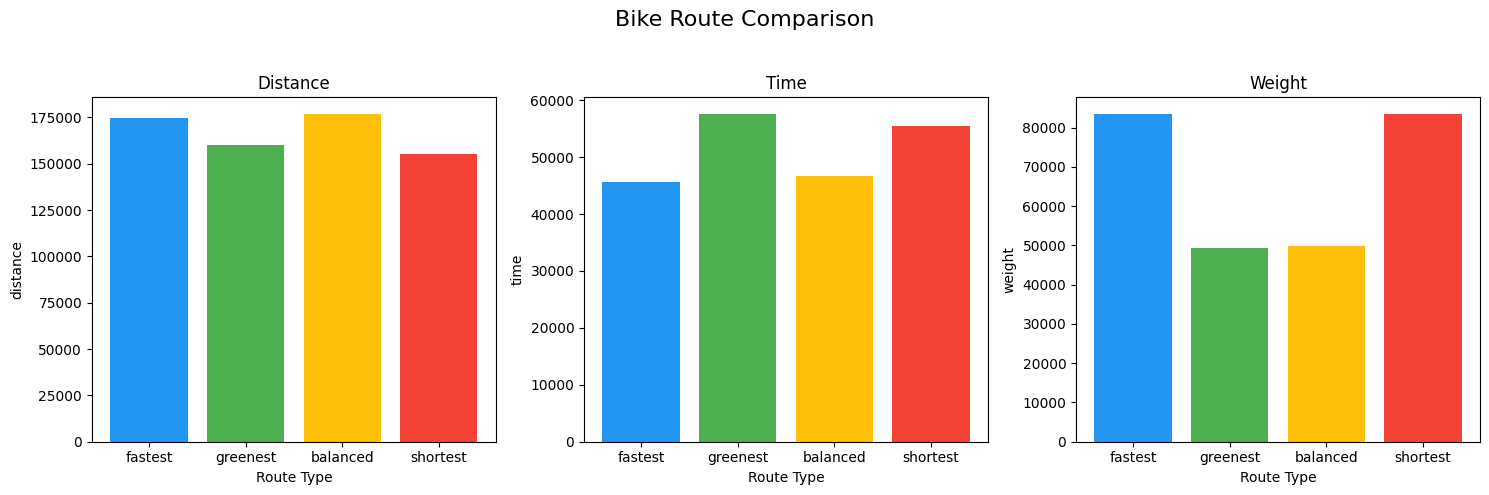


=== CAR ROUTE COMPARISON ===
           distance      time    weight
category                               
fastest   181570.14  50140.61  88548.54
greenest  168534.15  54307.70  51982.69
balanced  185604.23  50880.45  52282.84
shortest  161659.58  53439.58  84309.04


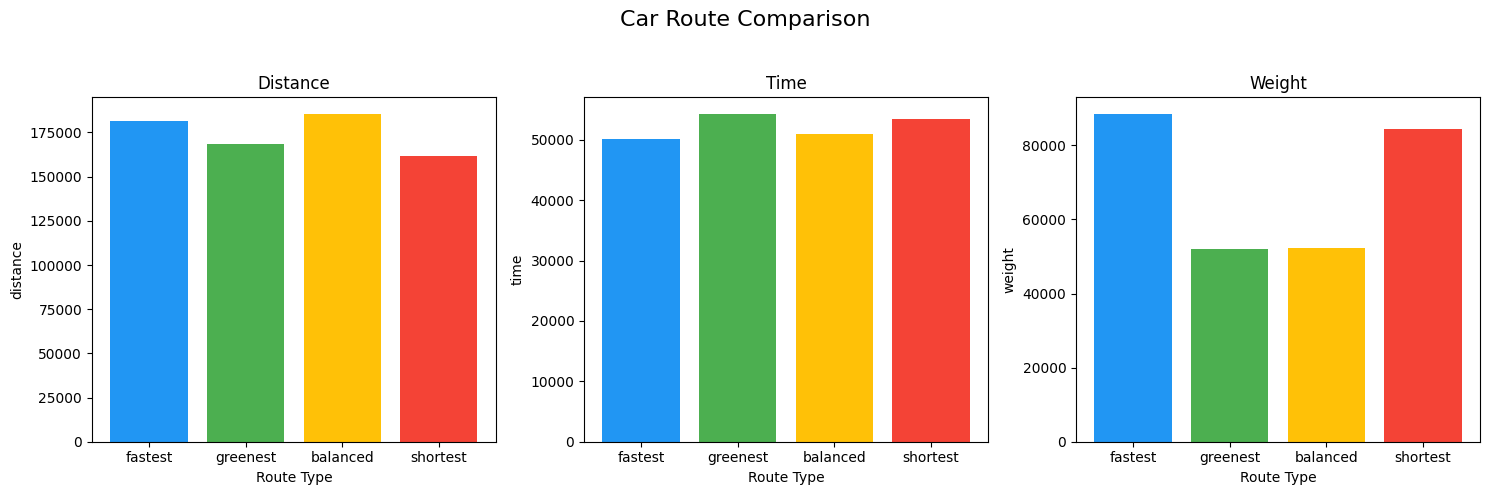


=== FOOT ROUTE COMPARISON ===
           distance      time    weight
category                               
fastest   115293.11  44286.96  80265.31
greenest  110913.30  53731.95  45049.89
balanced  117165.80  45728.63  46015.81
shortest  103979.54  48694.34  80269.91


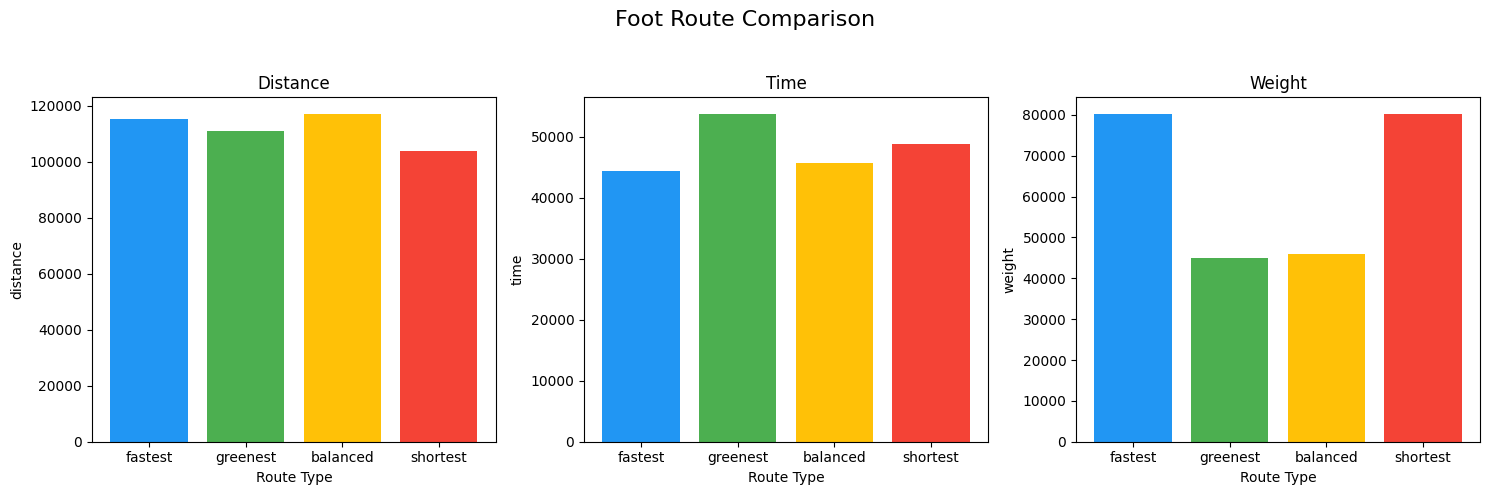


=== MOTORCYCLE ROUTE COMPARISON ===
           distance      time    weight
category                               
fastest   183058.92  50545.18  95227.71
greenest  169423.83  54665.97  51564.78
balanced  186796.25  51241.35  51858.85
shortest  162632.60  53825.17  84240.68


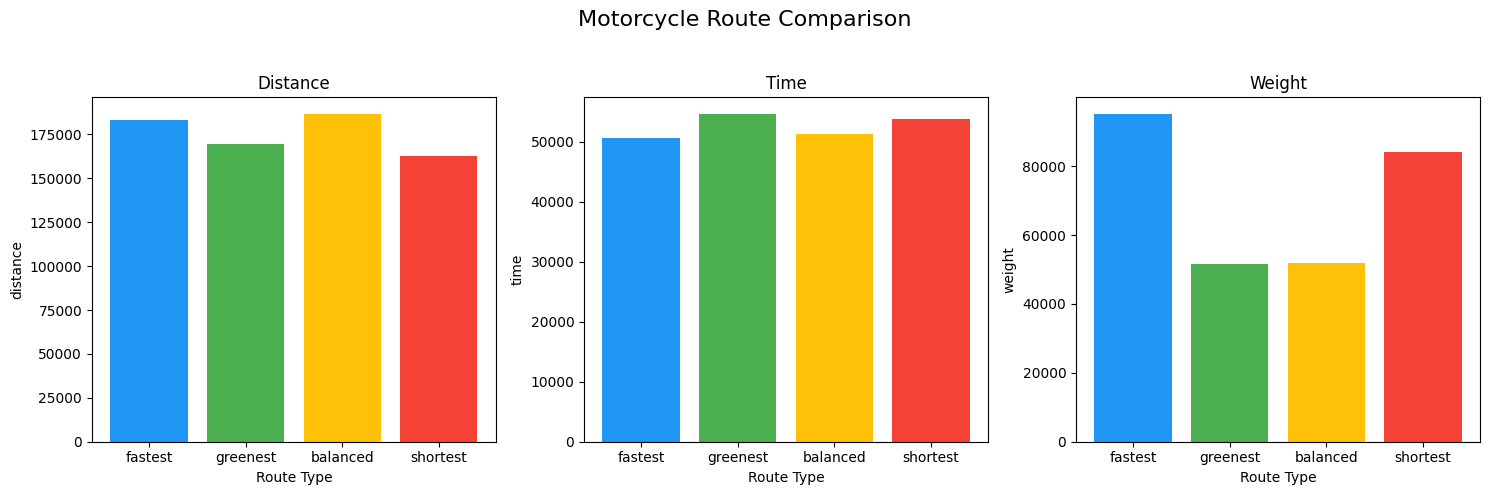

In [61]:
agg_df = df.groupby(['vehicle', 'category'])[['distance', 'time', 'weight']].mean().reset_index()

vehicles = agg_df['vehicle'].unique()

category_order = ['fastest', 'greenest', 'balanced', 'shortest']

for vehicle in vehicles:
    print(f"\n=== {vehicle.upper()} ROUTE COMPARISON ===")
    print(
        agg_df[agg_df['vehicle'] == vehicle]
        .set_index('category')
        .loc[['fastest', 'greenest', 'balanced', 'shortest']]
        [['distance', 'time', 'weight']]
        .round(2)
    )


    sub_df = (
        agg_df[agg_df['vehicle'] == vehicle]
        .set_index('category')
        .loc[category_order]
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{vehicle.capitalize()} Route Comparison", fontsize=16)

    for i, metric in enumerate(['distance', 'time', 'weight']):
        axes[i].bar(sub_df.index, sub_df[metric], color=['#2196F3', '#4CAF50', '#FFC107', '#F44336'])
        axes[i].set_title(metric.capitalize())
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel("Route Type")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

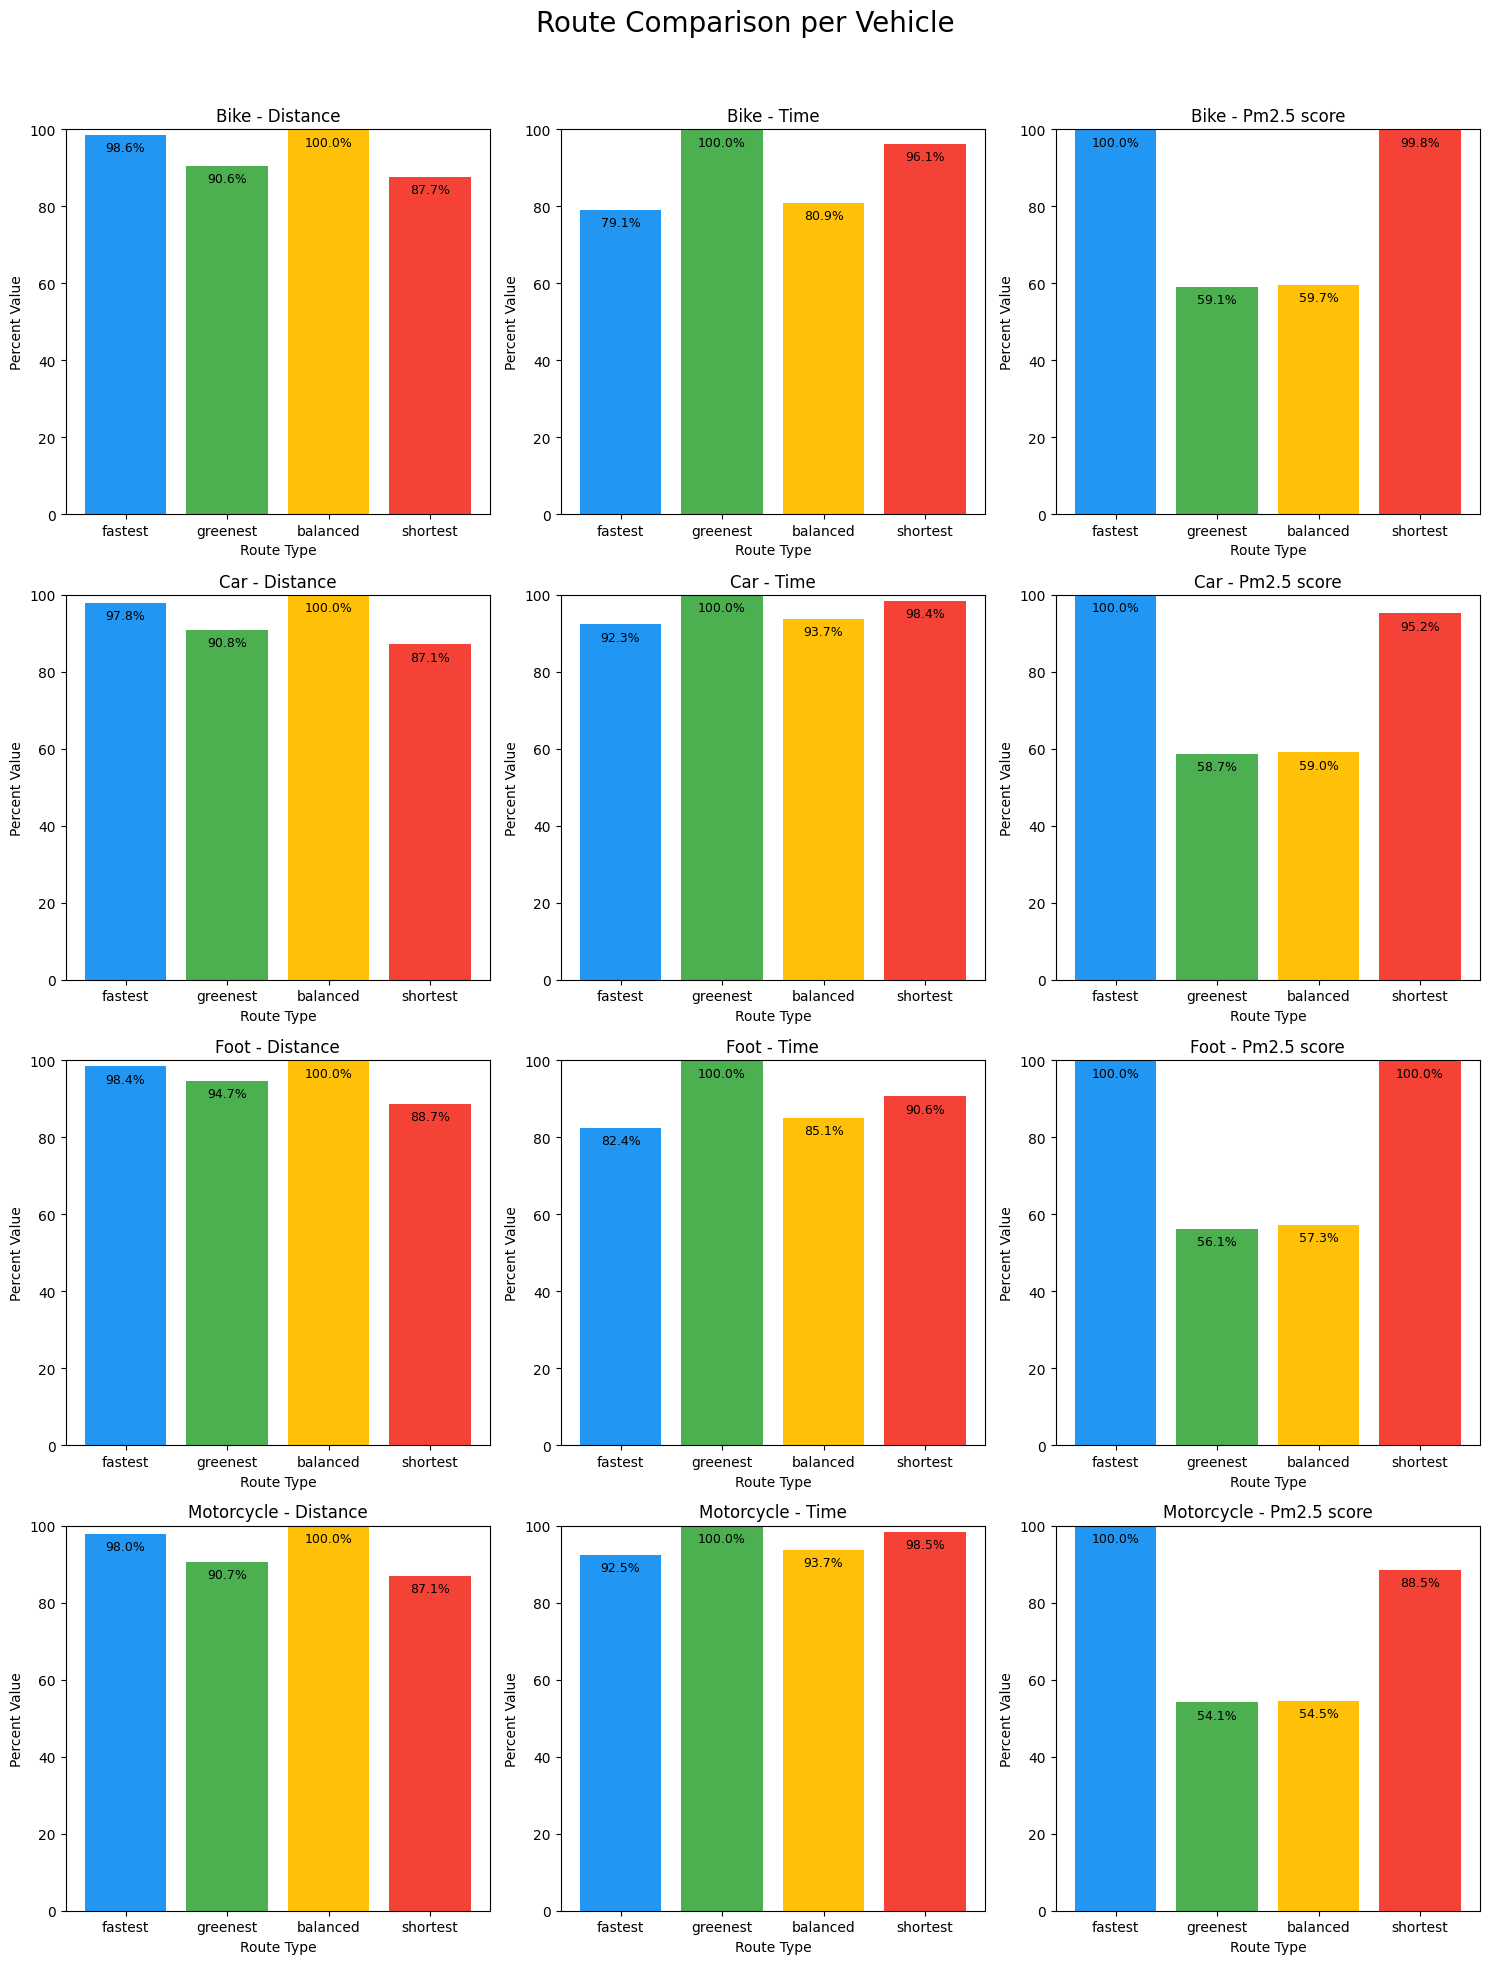

In [62]:
agg_df = df.groupby(['vehicle', 'category'])[['distance', 'time', 'weight']].mean().reset_index()

def normalize_group(group):
    return group / group.max()

agg_df[['distance', 'time', 'weight']] = (
    agg_df.groupby('vehicle')[['distance', 'time', 'weight']].transform(normalize_group) * 100
)

category_order = ['fastest', 'greenest', 'balanced', 'shortest']
agg_df['category'] = pd.Categorical(agg_df['category'], categories=category_order, ordered=True)

color_map = {
    'fastest': '#2196F3',
    'greenest': '#4CAF50',
    'balanced': '#FFC107',
    'shortest': '#F44336'
}

vehicles = sorted(agg_df['vehicle'].unique())
num_vehicles = len(vehicles)

fig, axes = plt.subplots(num_vehicles, 3, figsize=(15, 5 * num_vehicles), squeeze=False)
fig.suptitle("Route Comparison per Vehicle", fontsize=20)

for i, vehicle in enumerate(vehicles):
    vdf = agg_df[agg_df['vehicle'] == vehicle].set_index('category').loc[category_order]
    
    for j, metric in enumerate(['distance', 'time', 'weight']):
        ax = axes[i, j]
        bars = vdf[metric]
        bar_container = ax.bar(bars.index, bars.values, color=[color_map[cat] for cat in bars.index])
        ax.set_ylim(0, 100)

        if metric == 'weight':
            metric = 'PM2.5 Score'
        ax.set_title(f"{vehicle.capitalize()} - {metric.capitalize()}")
        ax.set_ylabel("Percent Value")
        ax.set_xlabel("Route Type")

        for bar in bar_container:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height - 5,
                f"{height:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()